# Otimização de Rede Neural com Algoritmo Genético para Classificação MNIST
Este projeto implementa um Algoritmo Genético (GA) para otimizar os hiperparâmetros de uma rede neural feedforward (`MLPClassifier`) para a tarefa de classificação de dígitos manuscritos do dataset MNIST.

**Autor:** Agnelo Pereira Lima Júnior

**Disciplina:** Computação Natural

## Estrutura do Projeto

O código está organizado em um Jupyter Notebook com 5 células sequenciais, cada uma com um propósito específico:

1.  **Configuração e Importações**: Carregamento das bibliotecas.
2.  **Preparação dos Dados**: Download e pré-processamento do dataset MNIST.
3.  **Definição do Algoritmo Genético**: Implementação das funções do GA (fitness, seleção, etc.).
4.  **Execução da Otimização**: O loop principal do GA, que é a etapa mais demorada.
5.  **Análise Final**: Treinamento e avaliação do modelo com os melhores parâmetros encontrados.

---



Instalar os Pacotes Pyrhon

In [17]:
# Instale pacotes python 
!pip install numpy scikit-learn matplotlib
!pip install pandas
!pip install seaborn
!python -m pip install --upgrade pip


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.1.1
    Uninstalling pip-25.1.1:
      Successfully uninstalled pip-25.1.1


## 1: Importar Bibliotecas e Preparar os Dados

Nesta primeira parte, importamos tudo o que precisamos e definimos uma função para carregar o dataset MNIST. A função `preparar_dados` baixa os dados, normaliza os valores dos pixels para o intervalo entre 0 e 1, e divide o conjunto em treino e teste.

## 2: Preparação dos Dados
Esta célula define a função para carregar e pré-processar o dataset MNIST e, em seguida, a executa. Ao final, teremos os dados de treino e teste prontos para uso nas variáveis.

In [24]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignorar avisos para uma saída mais limpa durante a otimização
warnings.filterwarnings("ignore", category=ConvergenceWarning)

print("Bibliotecas importadas com sucesso.")

def preparar_dados():
    """Carrega o dataset MNIST e o prepara para o treinamento."""
    print("Carregando o dataset MNIST... (pode levar um momento)")
    try:
        mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
    except Exception as e:
        print(f"Falha ao carregar o dataset. Verifique sua conexão com a internet. Erro: {e}")
        return None, None, None, None
    
    X = mnist.data.astype('float32') / 255.0
    y = mnist.target.astype('int64')
    
    x_train, x_test = X[:60000], X[60000:]
    y_train, y_test = y[:60000], y[60000:]
    
    print("Dados carregados e preparados.")
    return x_train, y_train, x_test, y_test

# Executa a preparação dos dados
x_train_data, y_train_data, x_test_data, y_test_data = preparar_dados()

Bibliotecas importadas com sucesso.
Carregando o dataset MNIST... (pode levar um momento)
Dados carregados e preparados.



## 3: Definição da Lógica do Algoritmo Genético
Esta célula contém todas as funções que definem o comportamento do nosso Algoritmo Genético: a função de fitness, e os operadores de inicialização, seleção, cruzamento e mutação.

## **Funções do Algoritmo Genético**

Este conjunto de funções implementa um ciclo evolutivo para otimizar os hiperparâmetros de uma rede neural.

### `inicializar_populacao()`
Esta função dá início ao processo, criando a primeira geração de soluções.
- Gera uma **população** (lista) de **indivíduos** (dicionários).
- Cada indivíduo recebe uma combinação aleatória de hiperparâmetros (genes), como taxa de aprendizado e arquitetura da rede.
- **Para:** Criar a diversidade genética inicial para a busca.

### `calcular_fitness()`
É a função que avalia a qualidade de cada solução. Atua como o "ambiente" que testa a aptidão de cada indivíduo.
- Recebe um **indivíduo** (um conjunto de hiperparâmetros).
- Constrói e treina um `MLPClassifier` temporário com essa configuração específica.
- Retorna a **acurácia** do modelo no conjunto de teste como seu valor de **fitness**.
- **Para:** Quantificar o desempenho de cada solução para guiar o processo de seleção.

#### `selecao()`
Implementa o princípio da "sobrevivência do mais apto", selecionando os indivíduos que irão gerar a próxima geração.
- Utiliza a **seleção por torneio**: sorteia dois indivíduos aleatoriamente e seleciona aquele com o maior fitness.
- Cria uma nova população de "pais" a partir dos indivíduos mais promissores da geração atual.
- **Para:** Garantir que as características das melhores soluções sejam propagadas.

#### `cruzamento()`
Simula a reprodução, criando novas soluções ("filhos") a partir da combinação de dois "pais".
- Recebe dois indivíduos pais.
- Com uma certa probabilidade (taxa de cruzamento), gera um "filho" que herda uma mistura dos hiperparâmetros dos pais.
- **Para:** Explorar novas combinações de características que podem resultar em soluções ainda melhores.

#### `mutacao()`
Introduz pequenas e aleatórias alterações genéticas para manter a diversidade na população.
- Com uma pequena probabilidade (taxa de mutação), altera aleatoriamente o valor de um dos hiperparâmetros de um indivíduo.
- **Para:** Evitar que o algoritmo fique preso em uma solução subótima (ótimo local) e explorar novas áreas do espaço de busca.

In [25]:
def calcular_fitness(individuo, x_train, y_train, x_test, y_test):
    """Função de fitness: cria, treina e avalia um MLPClassifier."""
    print(f"\nAvaliando indivíduo: {individuo}")
    start_time = time.time()
    mlp = MLPClassifier(
        hidden_layer_sizes=tuple(individuo['neuronios_por_camada']),
        learning_rate_init=individuo['taxa_aprendizado'],
        batch_size=individuo['batch_size'],
        activation='relu', solver='adam', max_iter=30, random_state=1
    )
    # Usa uma amostra dos dados para acelerar
    indices = np.random.choice(len(x_train), 15000, replace=False)
    mlp.fit(x_train[indices], y_train[indices])
    acuracia = accuracy_score(y_test, mlp.predict(x_test))
    end_time = time.time()
    print(f"Fitness (Acurácia): {acuracia:.4f} | Tempo: {end_time - start_time:.2f}s")
    return acuracia

def inicializar_populacao(tamanho_populacao):
    """Cria a população inicial com indivíduos aleatórios."""
    populacao = []
    for _ in range(tamanho_populacao):
        num_camadas = random.randint(1, 3)
        neuronios = [random.choice([64, 128, 256]) for _ in range(num_camadas)]
        individuo = {
            'taxa_aprendizado': random.choice([0.005, 0.001, 0.0005]),
            'neuronios_por_camada': neuronios,
            'batch_size': random.choice([128, 256])
        }
        populacao.append(individuo)
    return populacao

def selecao(populacao, fitnesses):
    """Seleciona os melhores indivíduos para a próxima geração (torneio)."""
    proxima_geracao = []
    for _ in range(len(populacao)):
        i, j = random.sample(range(len(populacao)), 2)
        if fitnesses[i] > fitnesses[j]:
            proxima_geracao.append(populacao[i])
        else:
            proxima_geracao.append(populacao[j])
    return proxima_geracao

def cruzamento(pai1, pai2, taxa_cruzamento):
    """Realiza o cruzamento entre dois pais para gerar um filho."""
    if random.random() < taxa_cruzamento:
        filho = {
            'taxa_aprendizado': random.choice([pai1['taxa_aprendizado'], pai2['taxa_aprendizado']]),
            'batch_size': random.choice([pai1['batch_size'], pai2['batch_size']])
        }
        pai_estrutura = random.choice([pai1, pai2])
        filho['neuronios_por_camada'] = pai_estrutura['neuronios_por_camada'][:]
        return filho
    return random.choice([pai1, pai2]).copy()

def mutacao(individuo, taxa_mutacao):
    """Aplica mutações aleatórias em um indivíduo."""
    if random.random() < taxa_mutacao:
        param_mutado = random.choice(list(individuo.keys()))
        if param_mutado == 'taxa_aprendizado':
            individuo['taxa_aprendizado'] = random.choice([0.005, 0.001, 0.0005])
        elif param_mutado == 'batch_size':
            individuo['batch_size'] = random.choice([128, 256, 512])
        elif param_mutado == 'neuronios_por_camada':
            idx_camada = random.randint(0, len(individuo['neuronios_por_camada']) - 1)
            individuo['neuronios_por_camada'][idx_camada] = random.choice([64, 128, 256, 512])
    return individuo

print("Funções do Algoritmo Genético definidas.")

Funções do Algoritmo Genético definidas.


## 4: Execução da Otimização com GA (Célula Demorada)
Esta é a célula principal da otimização. Ela define a **Função `rodar_ga()`** e a executa. Esta célula levará um tempo considerável para ser concluída. Ao final, ela exibirá o melhor conjunto de hiperparâmetros encontrado e o gráfico de convergência.



Iniciando o Algoritmo Genético...

======= GERAÇÃO 1/10 =======

Avaliando indivíduo: {'taxa_aprendizado': 0.005, 'neuronios_por_camada': [256, 64], 'batch_size': 256}
Fitness (Acurácia): 0.9693 | Tempo: 26.13s

Avaliando indivíduo: {'taxa_aprendizado': 0.005, 'neuronios_por_camada': [64], 'batch_size': 256}
Fitness (Acurácia): 0.9591 | Tempo: 4.62s

Avaliando indivíduo: {'taxa_aprendizado': 0.005, 'neuronios_por_camada': [128, 128], 'batch_size': 128}
Fitness (Acurácia): 0.9661 | Tempo: 47.81s

Avaliando indivíduo: {'taxa_aprendizado': 0.0005, 'neuronios_por_camada': [64, 128, 256], 'batch_size': 128}
Fitness (Acurácia): 0.9586 | Tempo: 46.64s

Avaliando indivíduo: {'taxa_aprendizado': 0.005, 'neuronios_por_camada': [64, 128], 'batch_size': 256}
Fitness (Acurácia): 0.9681 | Tempo: 7.08s

Avaliando indivíduo: {'taxa_aprendizado': 0.001, 'neuronios_por_camada': [64, 256, 256], 'batch_size': 256}
Fitness (Acurácia): 0.9643 | Tempo: 13.66s

Avaliando indivíduo: {'taxa_aprendizado': 0.000

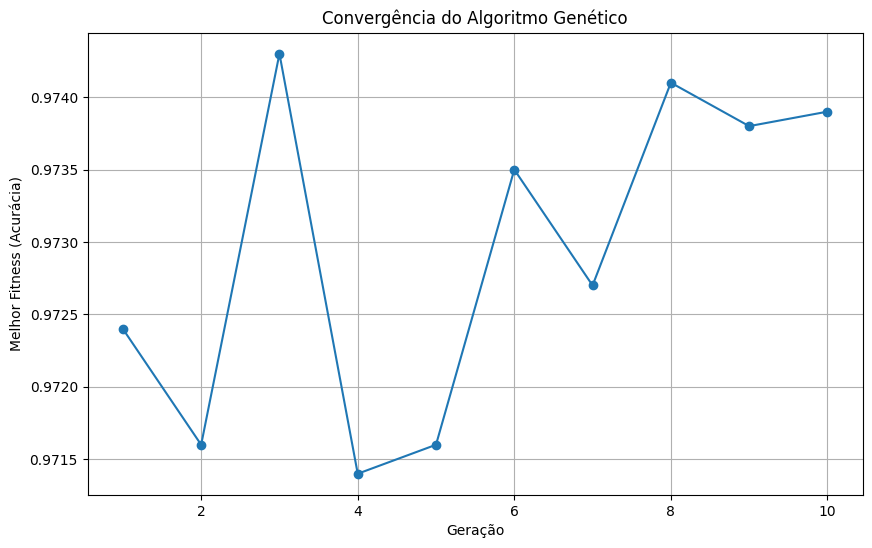


Otimização do GA concluída! Execute a próxima célula para a análise final.


In [26]:
def rodar_ga(x_train, y_train, x_test, y_test, num_geracoes=10, tam_populacao=15, taxa_cruzamento=0.8, taxa_mutacao=0.2):
    """Função principal que executa o loop do GA."""
    print("\nIniciando o Algoritmo Genético...")
    populacao = inicializar_populacao(tam_populacao)
    melhor_individuo_geral, melhor_fitness_geral, historico_fitness = None, 0, []
    for geracao in range(num_geracoes):
        print(f"\n======= GERAÇÃO {geracao + 1}/{num_geracoes} =======")
        fitnesses = [calcular_fitness(ind, x_train, y_train, x_test, y_test) for ind in populacao]
        melhor_fitness_geracao = max(fitnesses)
        historico_fitness.append(melhor_fitness_geracao)
        if melhor_fitness_geracao > melhor_fitness_geral:
            melhor_fitness_geral = melhor_fitness_geracao
            melhor_individuo_geral = populacao[np.argmax(fitnesses)]
        print(f"\nMelhor fitness da Geração {geracao + 1}: {melhor_fitness_geracao:.4f}")
        selecionados = selecao(populacao, fitnesses)
        proxima_geracao = []
        for _ in range(tam_populacao):
            pai1, pai2 = random.choice(selecionados), random.choice(selecionados)
            filho = cruzamento(pai1, pai2, taxa_cruzamento)
            proxima_geracao.append(mutacao(filho, taxa_mutacao))
        populacao = proxima_geracao
    print(f"\n======= OTIMIZAÇÃO CONCLUÍDA =======")
    print(f"Melhor indivíduo encontrado: {melhor_individuo_geral}")
    print(f"Melhor fitness (acurácia): {melhor_fitness_geral:.4f}")
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_geracoes + 1), historico_fitness, marker='o', linestyle='-')
    plt.title('Convergência do Algoritmo Genético'); plt.xlabel('Geração'); plt.ylabel('Melhor Fitness (Acurácia)'); plt.grid(True); plt.show()
    return melhor_individuo_geral

# Executa a otimização
if 'x_train_data' in locals():
    melhores_hiperparametros = rodar_ga(x_train_data, y_train_data, x_test_data, y_test_data)
    print("\nOtimização do GA concluída! Execute a próxima célula para a análise final.")
else:
    print("Dados não foram carregados. Execute a Célula 2 primeiro.")

## 5: Análise Final do Modelo Otimizado (Célula Rápida)
Execute esta célula após a Célula 4 terminar. Ela pegará os `melhores_hiperparametros` encontrados, treinará um único modelo final com mais dedicação e gerará o relatório de classificação completo e a matriz de confusão.


======= TREINAMENTO E AVALIAÇÃO DO MODELO FINAL =======
Treinando o modelo final com os dados completos...
Iteration 1, loss = 0.22004504
Iteration 2, loss = 0.08559256
Iteration 3, loss = 0.06439381
Iteration 4, loss = 0.04997500
Iteration 5, loss = 0.04138909
Iteration 6, loss = 0.03596936
Iteration 7, loss = 0.03143465
Iteration 8, loss = 0.03323782
Iteration 9, loss = 0.03314795
Iteration 10, loss = 0.03340692
Iteration 11, loss = 0.02603129
Iteration 12, loss = 0.02305263
Iteration 13, loss = 0.02626243
Iteration 14, loss = 0.03041665
Iteration 15, loss = 0.02650210
Iteration 16, loss = 0.01734298
Iteration 17, loss = 0.01749260
Iteration 18, loss = 0.02939380
Iteration 19, loss = 0.02407524
Iteration 20, loss = 0.01700839
Iteration 21, loss = 0.02319311
Iteration 22, loss = 0.02060267
Iteration 23, loss = 0.02343801
Iteration 24, loss = 0.02605817
Iteration 25, loss = 0.01648833
Iteration 26, loss = 0.02161059
Iteration 27, loss = 0.01827011
Iteration 28, loss = 0.02213630
Itera

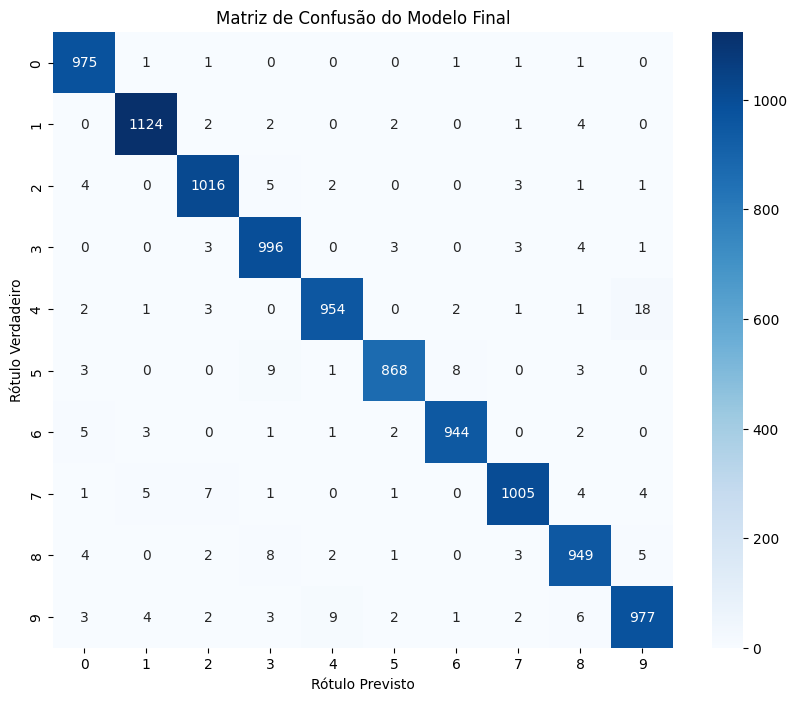


Valores da Matriz de Confusão:
[[ 975    1    1    0    0    0    1    1    1    0]
 [   0 1124    2    2    0    2    0    1    4    0]
 [   4    0 1016    5    2    0    0    3    1    1]
 [   0    0    3  996    0    3    0    3    4    1]
 [   2    1    3    0  954    0    2    1    1   18]
 [   3    0    0    9    1  868    8    0    3    0]
 [   5    3    0    1    1    2  944    0    2    0]
 [   1    5    7    1    0    1    0 1005    4    4]
 [   4    0    2    8    2    1    0    3  949    5]
 [   3    4    2    3    9    2    1    2    6  977]]

--- Comparação com o Artigo ---
Acurácia Final Obtida: 0.9808
Acurácia do Artigo (com GA): 98.85%

Tempo total de treinamento e avaliação final: 1420.30s


In [27]:
def avaliar_modelo_final(individuo, x_train, y_train, x_test, y_test):
    """Treina e avalia o modelo final, incluindo o relatório de classificação e a matriz de confusão."""
    if individuo is None:
        print("\nNenhum indivíduo para treinar. Encerrando.")
        return

    print("\n======= TREINAMENTO E AVALIAÇÃO DO MODELO FINAL =======")
    start_time = time.time()
    modelo_final = MLPClassifier(
        hidden_layer_sizes=tuple(individuo['neuronios_por_camada']),
        learning_rate_init=individuo['taxa_aprendizado'],
        batch_size=individuo['batch_size'],
        activation='relu', solver='adam', max_iter=100, verbose=True, random_state=1
    )
    print("Treinando o modelo final com os dados completos...")
    modelo_final.fit(x_train, y_train)
    print("\nRealizando predições e gerando relatório...")
    y_pred = modelo_final.predict(x_test)
    
    # 1. Relatório de Classificação Completo
    print("\n--- Relatório de Classificação Final (por dígito) ---")
    report = classification_report(y_test, y_pred)
    print(report)
    
    # 2. Matriz de Confusão
    print("\n--- Matriz de Confusão ---")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title('Matriz de Confusão do Modelo Final'); plt.ylabel('Rótulo Verdadeiro'); plt.xlabel('Rótulo Previsto'); plt.show()
    print("\nValores da Matriz de Confusão:")
    print(cm)
    
    # Resumo Final
    acuracia_final = accuracy_score(y_test, y_pred)
    print("\n--- Comparação com o Artigo ---")
    print(f"Acurácia Final Obtida: {acuracia_final:.4f}")
    print(f"Acurácia do Artigo (com GA): 98.85%")
    end_time = time.time()
    print(f"\nTempo total de treinamento e avaliação final: {end_time - start_time:.2f}s")

# Executa a análise final
if 'melhores_hiperparametros' in locals() and melhores_hiperparametros is not None:
    avaliar_modelo_final(melhores_hiperparametros, x_train_data, y_train_data, x_test_data, y_test_data)
else:
    print("Erro: A variável 'melhores_hiperparametros' não foi encontrada.")
    print("Por favor, execute a Célula 4 de otimização do GA primeiro.")